In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# Linear Algebra

## Q1: Condition number

For a linear system, ${\bf A x} = {\bf b}$, we can only solve for $x$ if the determinant of the matrix ${\bf A}$ is non-zero.  If the determinant is zero, then we call the matrix _singular_.  The _condition number_ of a matrix is a measure of how close we are to being singular.  The formal definition is:
\begin{equation}
\mathrm{cond}({\bf A}) = \| {\bf A}\| \| {\bf A}^{-1} \|
\end{equation}
But we can think of it as a measure of how much ${\bf x}$ would change due to a small change in ${\bf b}$.  A large condition number means that our solution for ${\bf x}$ could be inaccurate.

A _Hilbert matrix_ has $H_{ij} = (i + j + 1)^{-1}$, and is known to have a large condition number.  Here's a routine to generate a Hilbert matrix

In [2]:
def hilbert(n):
    """ return a Hilbert matrix, H_ij = (i + j - 1)^{-1} """

    H = np.zeros((n,n), dtype=np.float64)

    for i in range(1, n+1):
        for j in range(1, n+1):
            H[i-1,j-1] = 1.0/(i + j - 1.0)
    return H

Let's solve ${\bf Hx} ={\bf b}$.  Create a linear system by picking an ${\bf x}$ and generating a ${\bf b}$ by multiplying by the matrix ${\bf H}$.  Then use the `scipy.linalg.solve()` function to recover ${\bf x}$.  Compute the error in ${\bf x}$ as a function of the size of the matrix.

You won't need a large matrix, $n \sim 13$ or so, will start showing big errors.

You can compute the condition number with `numpy.linalg.cond()`

There are methods that can do a better job with nearly-singular matricies.  Take a look at `scipy.linalg.lstsq()` for example.

# FFTs

In [3]:
from scipy.integrate import ode

## Q2: FFT of chaotic pendulum

Last time we looked at ODEs and the chaotic pendulum, and were interested in writing a method to integrate the pendulum in time.

Here we want to examine its behavior in frequency space.  The code below will integrate the chaotic pendulum using a fixed dt, which makes it suitable for taking the FFT.

In [4]:
def rhs(t, Y, q, omega_d, b):
    """ damped driven pendulum system derivatives.  Here, Y = (theta, omega) are
        the solution variables. """
    f = np.zeros_like(Y)
        
    f[0] = Y[1]
    f[1] = -q*Y[1] - np.sin(Y[0]) + b*np.cos(omega_d*t)

    return f

def restrict_theta(theta):
    """ convert theta to be restricted to lie between -pi and pi"""
    tnew = theta + np.pi
    tnew += -2.0*np.pi*np.floor(tnew/(2.0*np.pi))
    tnew -= np.pi
    return tnew

def int_pendulum(theta0, q, omega_d, b, tend, dt):
    """ integrate the pendulum with a fixed timestep, dt"""
    r = ode(rhs)
    r.set_integrator("dopri5", nsteps=150000, first_step=dt, max_step=dt, dfactor=1.0)

    sol = []
    r.set_solout(lambda t, y: sol.append([t, *y]))

    t0 = 0.0
    omega0 = 0.0
    r.set_initial_value((theta0, omega0), t0)

    r.set_f_params(q, omega_d, b)

    r.integrate(tend)
    return np.array(sol)



The call below will give an undamped pendulum.  For a small amplitude, since we have $L = g$ in our pendulum, the period is simply $T = 2\pi$, and the frequency is $\nu_k = 1/(2\pi)$.  We plot things in terms of angular frequency, $\omega_k = 2\pi \nu_k$, so all the power will be at $\omega_k = 1$.

In [5]:
s = int_pendulum(np.radians(10), 0.0, 0.6666, 0.0, 200.0, 0.1)

Your task is to complete the power spectrum routine below to calculate the FFT of theta

In [11]:
def power_spectrum(t, theta0):
    """ return the power spectrum of theta.  For the frequency
        component, return it in terms of omega """

    theta = restrict_theta(theta0)
    
    # fill in the rest -- take the FFT of theta and return omega_k and 
    # the transform of theta
    N = len(t)    
    F = (2.0/N)*np.fft.rfft(theta)

    k = np.fft.rfftfreq(N)
    kfreq = 2.0*np.pi*k*N/max(t)

    return kfreq, F

In [12]:
omega, F = power_spectrum(s[:,0], s[:,1])

(0.0, 2.0)

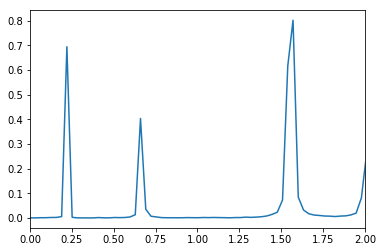

In [13]:
plt.plot(omega, np.abs(F)**2)
plt.xlim(0.0, 2.0)

In [14]:
s = int_pendulum(np.radians(60), 0.5, 0.6666, 1.6, 200.0, 0.1)

(0.0, 2.0)

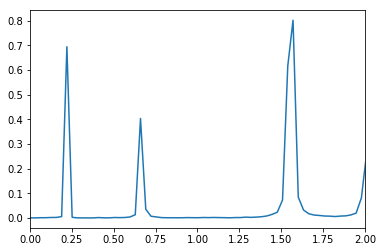

In [15]:
omega, F = power_spectrum(s[:,0], s[:,1])
plt.plot(omega, np.abs(F)**2)
plt.xlim(0.0, 2.0)

# Fitting

## Q3: Let's find the errors on our fit

We looked at fits, but not what the errors are on the fit.  Look at `scipy.optimize.curve_fit()`.  This is a simplified wrapper on the least squares fitting.  It can return the convariance matrix, the diagonals of which can give the error of the fit for the parameters.  

Make up some data that models a non-linear function (by introducing some random noise) and perform a fit and find the errors on the parameters.